<h1 style="color:#872325"> GridSearchCV </h1>

### Elaboró: Jorge Alberto Morúa Amaya
### Clave: 193699
### 21/04/2020

* Entrenar un modelo Lasso con GridSearchCV usando un pipeline de polinomios de segundo grado
* Graficar coeficientes "significativos"
* Revisar cuantos parámetros son mayores a 1e-2

In [17]:
## Hint: usando parámetros dentro de un pipeline
# para usar dentro de GridSearchCV
"""
pipe = Pipeline([
    "paso1": PolynomialFeatures(),
    "model": LinearRegression()
])

params = {
    "model__normalize": [True, False]
}

"""

'\npipe = Pipeline([\n    "paso1": PolynomialFeatures(),\n    "model": LinearRegression()\n])\n\nparams = {\n    "model__normalize": [True, False]\n}\n\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ridge_regression
from sklearn.model_selection import  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

In [3]:
#leemos el archivo
ipc_path = "../notebooks/ipc.xlsx" # Modificar a ruta
market = pd.read_excel(ipc_path, index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "") for c in market]
market.head()

,KIMBERA,GAPB,CEMEXCPO,ASURB,GFNORTEO,KOFUBL,AC*,LABB,FEMSAUBD,OMAB,...,MEGACPO,GCC*,BIMBOA,GMEXICOB,GCARSOA1,TLEVICPO,ALFAA,BSMXB,PINFRA*,MEXBOL
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73,42977.50
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93,42113.70
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56,42041.68
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80,41691.19
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75,40661.57


In [5]:
Rmkt = market.pct_change().dropna()

Xall = Rmkt.drop("MEXBOL", axis=1)
Xall = Xall.join(Rmkt["MEXBOL"].shift(1)).dropna()

Xtrain = Xall.drop("MEXBOL", axis=1)
ytrain = Xall["MEXBOL"]

#rendimiento
"""
R = market[["MEXBOL"]].diff()
R = R.join(R.shift(1).rename({"MEXBOL": "MEXBOL_0"}, axis=1)).dropna()
R.plot.scatter(x="MEXBOL_0", y="MEXBOL")
Xtrain = R[["MEXBOL_0"]]
ytrain = R[["MEXBOL"]]
Xtrain = np.c_[np.ones_like(Xtrain),Xtrain]
"""
test_period = "2019-12"
Xtest, ytest = Xtrain[test_period:], ytrain[test_period:]
Xtrain, ytrain = Xtrain[:"2019-11":], ytrain[:"2019-11"]

In [6]:
print(Xtrain.shape)
print(ytrain.shape)

(646, 35)
(646,)


In [7]:
fit_intercept = [True, False]
alphas = [0.8, 0.5, 0.2, 0.1, 0.05, 0.024, 0.02, 0.025, 0.026, 0.03]
#fit_intercept = fit_intercept
pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),
    ("lasso", Lasso())
])

params = {
    "lasso__alpha" : alphas
    #,"lasso__normalize": [True, False]
}

In [8]:
%%time
gsearch = GridSearchCV(pipe, params, scoring="neg_mean_absolute_error",
                       return_train_score=True, cv=10)
gsearch.fit(Xtrain, ytrain)
cvres = gsearch.cv_results_

Wall time: 8.42 s


In [9]:
cvres = gsearch.cv_results_
train_score = np.sqrt(-cvres["mean_train_score"])
test_score = np.sqrt(-cvres["mean_test_score"])

In [22]:
train_score.shape

(10,)

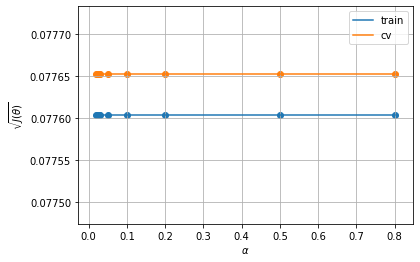

In [10]:
plt.plot(alphas, train_score, label="train")
plt.scatter(alphas, train_score)
plt.plot(alphas, test_score, label="cv")
plt.scatter(alphas, test_score)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sqrt{J(\theta)}$")
plt.legend(); plt.grid();

In [29]:
cv = cross_validate(gsearch.best_estimator_, Xtrain, ytrain, cv=10, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]
mae = -cv["test_neg_mean_absolute_error"]
intercept = gsearch.best_estimator_.named_steps['lasso'].intercept_.reshape(-1, 1)
print(f"mean r2: {r2.mean():0.2f}")
print(f"mean mae: {mae.mean():,.2f}")
print(f"intercept: {intercept[0]}")

mean r2: -0.01
mean mae: 0.01
intercept: [-0.00017092]


In [12]:
c_val = gsearch.best_estimator_.named_steps["lasso"].coef_
c_val

array([ 0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
        0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,
        0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -0., -0.,
       -0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0.,
        0.,  0.,  0.,  0., -0.,  0., -0., -0., -0.,  0., -0., -0., -0.,
       -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,
       -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
       -0., -0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0

In [35]:
c_val[c_val > 1e-2]
#NINGUN VALOR ES MAYOR A 1e-2

array([], dtype=float64)